In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Loading and Validating training labels for a multi-label image classification task.

In [45]:
import pandas as pd

with open('/kaggle/input/vr-chal/VRLChallenge_2.O/labels.txt', 'r') as f:
    labels = f.read().split()           

column_names = ['image_id'] + labels

df = pd.read_csv(
    '/kaggle/input/vr-chal/VRLChallenge_2.O/train.txt',
    delim_whitespace=True,  
    header=None,           
    names=column_names     
)

print(df.shape)            
print(df.head(10))        

print("Number of labels read:", len(labels))        
print("Columns in df (including image_id):", df.shape[1])  

print("Missing values per column:\n", df.isnull().sum().loc[lambda s: s>0])

(701, 50)
   image_id  UBCOLOR_black  UBCOLOR_blue  UBCOLOR_green  UBCOLOR_orange  \
0         1              1             0              0               0   
1         2              0             0              0               0   
2         3              0             0              0               0   
3         4              0             0              0               0   
4         5              1             0              0               0   
5         6              0             0              0               0   
6         7              0             0              0               0   
7         8              0             0              0               0   
8         9              0             0              0               0   
9        10              0             0              0               0   

   UBCOLOR_red  UBCOLOR_white  UBCOLOR_yellow  UBCOLOR_mix  UBCOLOR_other  \
0            0              0               0            0              0   
1         

/tmp/ipykernel_35/3363472884.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


In [33]:
labels_path = '/kaggle/input/vr-chal/VRLChallenge_2.O/labels.txt'
with open(labels_path, 'r') as f:
    labels = [l.strip() for l in f if l.strip()]   # → should be 49 names

print("Found", len(labels), "labels")               # expect 49

df = pd.read_csv(
    '/kaggle/input/vr-chal/VRLChallenge_2.O/train.txt',
    sep=r'\s+', header=None,
    names=['image_id'] + labels
)
print("DF columns:", df.shape[1])                   # expect 50


Found 49 labels
DF columns: 50


# Data preparation

In [47]:
import pandas as pd

labels_path = '/kaggle/input/vr-chal/VRLChallenge_2.O/labels.txt'
with open(labels_path, 'r') as f:
    labels = [l.strip() for l in f if l.strip()]
assert len(labels) == 49

df = pd.read_csv(
    '/kaggle/input/vr-chal/VRLChallenge_2.O/train.txt',
    sep=r'\s+', header=None,
    names=['image_id'] + labels
)

ub_simple = [
    'UBCOLOR_black','UBCOLOR_blue','UBCOLOR_green','UBCOLOR_orange',
    'UBCOLOR_red','UBCOLOR_white','UBCOLOR_yellow','UBCOLOR_other'
]
df.loc[df['UBCOLOR_mix']==1, ub_simple] = 0

lb_simple = [
    'LBCOLOR_black','LBCOLOR_blue','LBCOLOR_green','LBCOLOR_red',
    'LBCOLOR_yellow','LBCOLOR_white','LBCOLOR_orange','LBCOLOR_other'
]
df.loc[df['LBCOLOR_mix']==1, lb_simple] = 0

df['UBCOLOR_none'] = (df[ub_simple + ['UBCOLOR_mix']].sum(axis=1) == 0).astype(int)
df['LBCOLOR_none'] = (df[lb_simple + ['LBCOLOR_mix']].sum(axis=1) == 0).astype(int)
df['Carry_none']   = (df[['Carry_handbag','Carry_backpack','Carry_other']].sum(axis=1) == 0).astype(int)
df['Accessory_none']= (df[['Acc_headgear']].sum(axis=1)==0).astype(int)

df['UBClothing_none']  = (df[
    ['UB_jacket','UB_kurta','UB_other','UB_Saree',
     'UB_Shirt','UB_Suitwomen','UB_tshirt','UB_sweater']
].sum(axis=1) == 0).astype(int)

df['LBClothing_none']  = (df[
    ['LB_Leggings','LB_Salwar','LB_Shorts','LB_Trousers',
     'LB_Jeans','LB_Saree','LB_other']
].sum(axis=1) == 0).astype(int)

df['Footwear_none']    = (df[
    ['Foot_Sandals','Foot_shoes','Foot_slippers']
].sum(axis=1) == 0).astype(int)

df['Pose_none']        = (df[
    ['POSE_sitting','POSE_lying','POSE_standing']
].sum(axis=1) == 0).astype(int)

df['View_none']        = (df[
    ['VIEW_back','VIEW_front','VIEW_side']
].sum(axis=1) == 0).astype(int)

category_mapping = {
    'Upper Body Color':      ub_simple + ['UBCOLOR_mix','UBCOLOR_none'],
    'Lower Body Color':      lb_simple + ['LBCOLOR_mix','LBCOLOR_none'],
    'Upper Body Clothing':   ['UB_jacket','UB_kurta','UB_other','UB_Saree',
                               'UB_Shirt','UB_Suitwomen','UB_tshirt','UB_sweater',
                               'UBClothing_none'],
    'Lower Body Clothing':   ['LB_Leggings','LB_Salwar','LB_Shorts','LB_Trousers',
                               'LB_Jeans','LB_Saree','LB_other',
                               'LBClothing_none'],
    'Sleeves Length':        ['SLEEVES_long','SLEEVES_short','SLEEVES_none'],
    'Carry':                 ['Carry_handbag','Carry_backpack','Carry_other','Carry_none'],
    'Accessory':             ['Acc_headgear','Accessory_none'],
    'Footwear':              ['Foot_Sandals','Foot_shoes','Foot_slippers','Footwear_none'],
    'Pose':                  ['POSE_sitting','POSE_lying','POSE_standing','Pose_none'],
    'View':                  ['VIEW_back','VIEW_front','VIEW_side','View_none']
}

def enforce_one_hot(df, mapping):
    for cols in mapping.values():
        sums = df[cols].sum(axis=1)
        mask_gt1 = sums > 1
        for idx in df.index[mask_gt1]:
            active = [c for c in cols if df.at[idx, c] == 1]
            for c in active[1:]:
                df.at[idx, c] = 0
                
        mask_eq0 = df[cols].sum(axis=1) == 0
        none_flag = [c for c in cols if c.endswith('none')]
        if none_flag:
            df.loc[mask_eq0, none_flag[0]] = 1

    return df

df = enforce_one_hot(df, category_mapping)

print("Category sums:")
for cat, cols in category_mapping.items():
    uniques = sorted(df[cols].sum(axis=1).unique())
    print(f"  {cat:20s}: {uniques}")


Category sums:
  Upper Body Color    : [1]
  Lower Body Color    : [1]
  Upper Body Clothing : [1]
  Lower Body Clothing : [1]
  Sleeves Length      : [1]
  Carry               : [1]
  Accessory           : [1]
  Footwear            : [1]
  Pose                : [1]
  View                : [1]


# Visualization

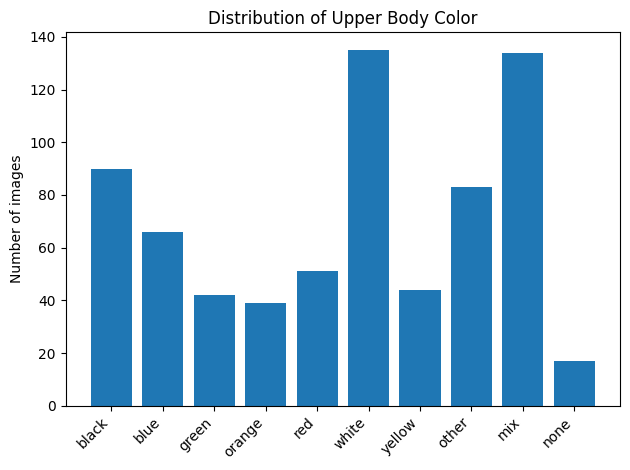

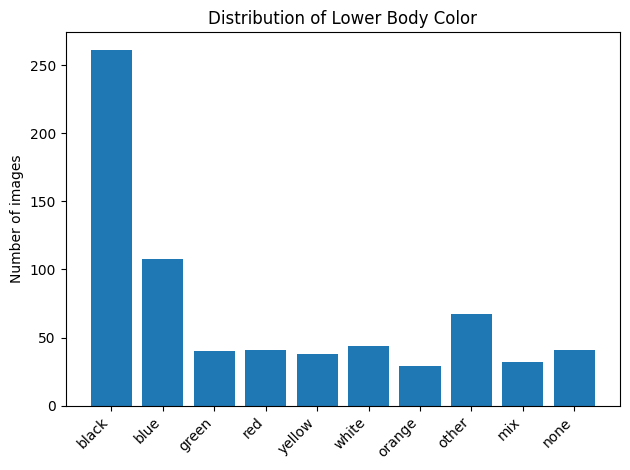

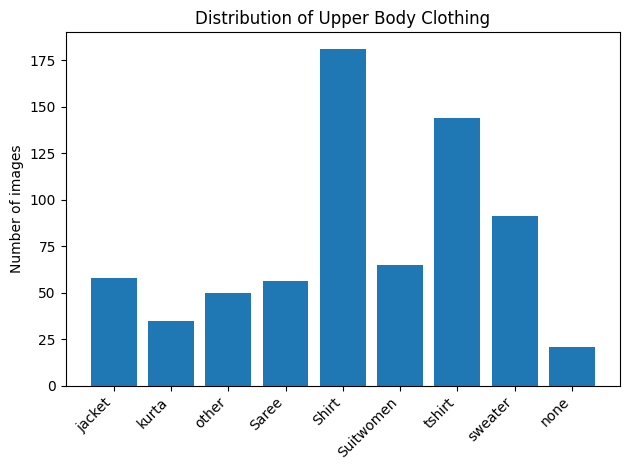

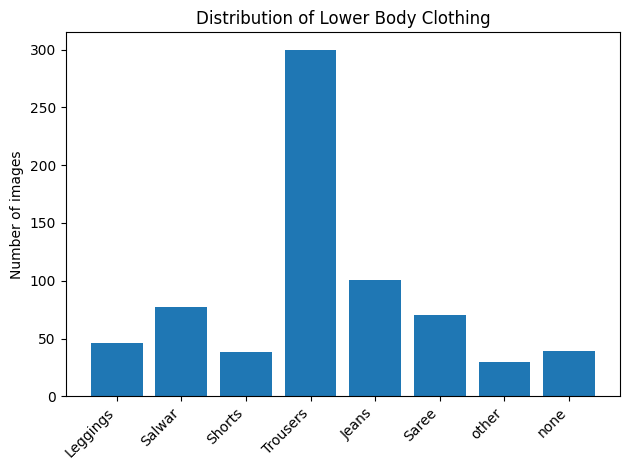

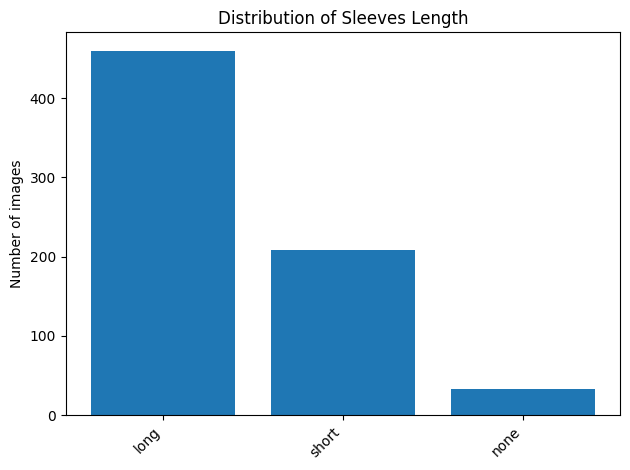

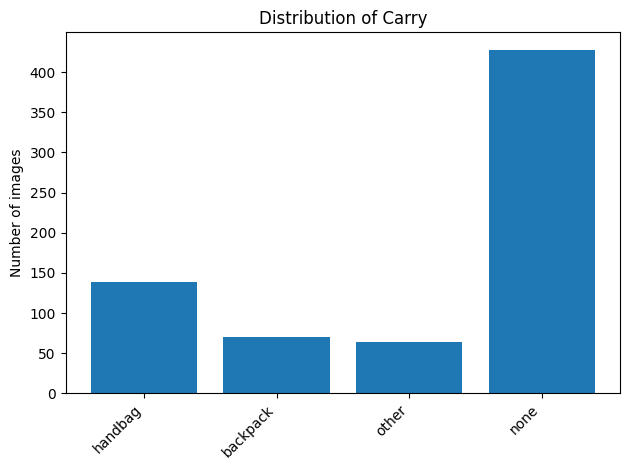

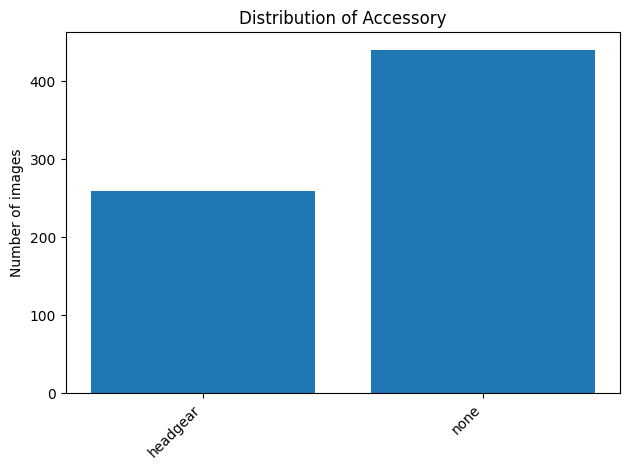

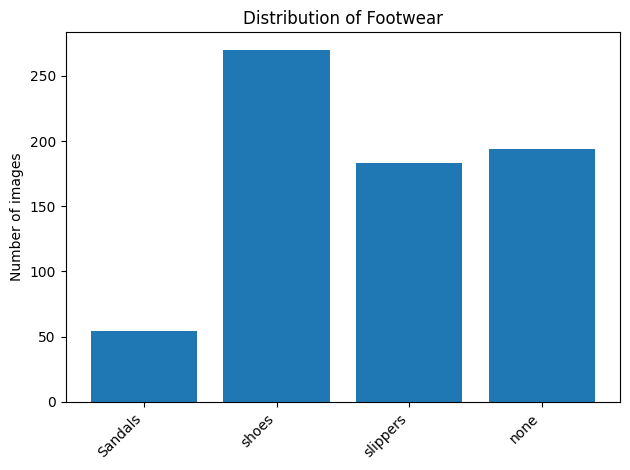

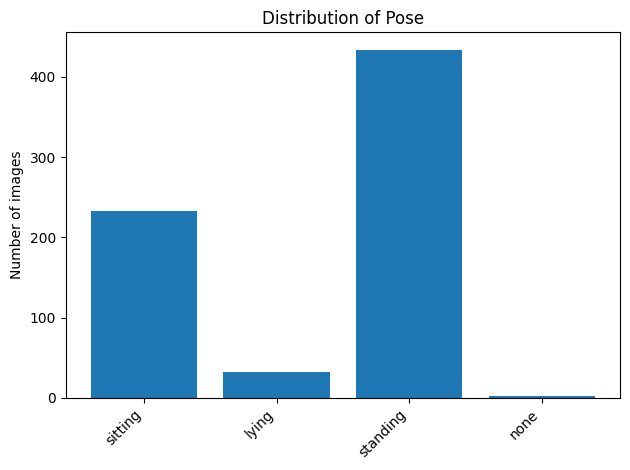

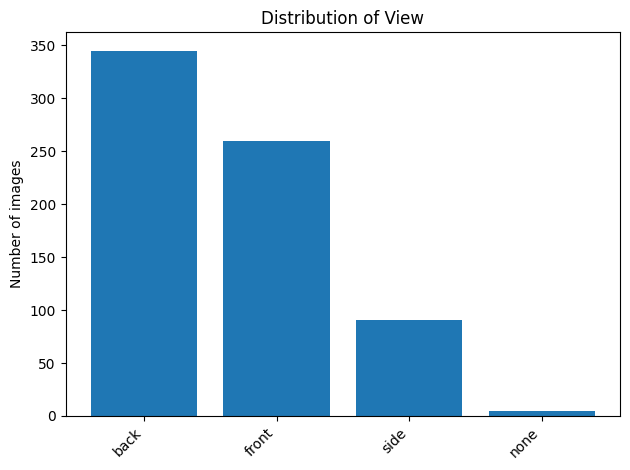

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

for category, cols in category_mapping.items():
    counts = df[cols].sum().values
    labels_short = [c.split('_', 1)[1] for c in cols]
    
    plt.figure()
    plt.bar(labels_short, counts)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Number of images')
    plt.title(f'Distribution of {category}')
    plt.tight_layout()
    plt.show()


# Distribution

In [5]:
for category, cols in category_mapping.items():
    counts = df[cols].sum()
    labels_short = [c.split('_', 1)[1] for c in cols]
    print(f"Distribution for {category}:")
    for label, cnt in zip(labels_short, counts):
        print(f"  {label:10s}: {cnt}")
    print()

Distribution for Upper Body Color:
  black     : 90
  blue      : 66
  green     : 42
  orange    : 39
  red       : 51
  white     : 135
  yellow    : 44
  other     : 83
  mix       : 134
  none      : 17

Distribution for Lower Body Color:
  black     : 261
  blue      : 108
  green     : 40
  red       : 41
  yellow    : 38
  white     : 44
  orange    : 29
  other     : 67
  mix       : 32
  none      : 41

Distribution for Upper Body Clothing:
  jacket    : 58
  kurta     : 35
  other     : 50
  Saree     : 56
  Shirt     : 181
  Suitwomen : 65
  tshirt    : 144
  sweater   : 91
  none      : 21

Distribution for Lower Body Clothing:
  Leggings  : 46
  Salwar    : 77
  Shorts    : 38
  Trousers  : 300
  Jeans     : 101
  Saree     : 70
  other     : 30
  none      : 39

Distribution for Sleeves Length:
  long      : 460
  short     : 208
  none      : 33

Distribution for Carry:
  handbag   : 139
  backpack  : 70
  other     : 64
  none      : 428

Distribution for Accessory:
  h

# Data cleaning and encoding process

In [51]:
import pandas as pd
category_df = pd.DataFrame({
    cat: df[cols].sum(axis=1)
    for cat, cols in category_mapping.items()
})

mask     = category_df.eq(1).all(axis=1)
df_clean = df[mask].reset_index(drop=True)
print(f"Kept {len(df_clean)} / {len(df)} images after enforcing 1 label each.")

for cat, cols in category_mapping.items():
    idx_col = cat.replace(' ', '_') + '_idx'
    df_clean[idx_col] = (
        df_clean[cols]
            .idxmax(axis=1)                      
            .map(lambda c: cols.index(c))      
    )

label_cols = [c.replace(' ', '_') + '_idx' for c in category_mapping]
print(df_clean[label_cols].head())
print("\nUnique label values per category:")
for lc in label_cols:
    print(f"  {lc:25s}: {sorted(df_clean[lc].unique())}")


Kept 701 / 701 images after enforcing 1 label each.
   Upper_Body_Color_idx  Lower_Body_Color_idx  Upper_Body_Clothing_idx  \
0                     0                     8                        6   
1                     8                     5                        7   
2                     5                     0                        4   
3                     8                     0                        8   
4                     0                     1                        8   

   Lower_Body_Clothing_idx  Sleeves_Length_idx  Carry_idx  Accessory_idx  \
0                        2                   1          0              1   
1                        3                   0          0              0   
2                        3                   0          0              1   
3                        3                   1          3              1   
4                        3                   0          3              0   

   Footwear_idx  Pose_idx  View_idx  
0       

In [52]:
for cat, cols in category_mapping.items():
    df_clean[f"{cat}_idx"] = (
        df_clean[cols]
          .idxmax(axis=1)                     
          .map(lambda c: cols.index(c))      
    )
print(df_clean[[f"{cat}_idx" for cat in category_mapping]].head())

   Upper Body Color_idx  Lower Body Color_idx  Upper Body Clothing_idx  \
0                     0                     8                        6   
1                     8                     5                        7   
2                     5                     0                        4   
3                     8                     0                        8   
4                     0                     1                        8   

   Lower Body Clothing_idx  Sleeves Length_idx  Carry_idx  Accessory_idx  \
0                        2                   1          0              1   
1                        3                   0          0              0   
2                        3                   0          0              1   
3                        3                   1          3              1   
4                        3                   0          3              0   

   Footwear_idx  Pose_idx  View_idx  
0             3         2         0  
1             1       

# Dataset splitting

In [53]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    df_clean,
    test_size=0.30,
    stratify=df_clean['Upper_Body_Clothing_idx'],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df['Upper_Body_Clothing_idx'],
    random_state=42
)

print(f"Train: {len(train_df)} images")
print(f"Validation: {len(val_df)} images")
print(f"Test: {len(test_df)} images")

dist = train_df['Upper_Body_Clothing_idx'].value_counts(normalize=True).sort_index()
print("\nUpper Body Clothing proportions in TRAIN:")
print(dist.to_frame(name='proportion'))

label_cols = [f"{cat.replace(' ', '_')}_idx" for cat in category_mapping]

for lc in label_cols:
    print(f"\n=== {lc} proportions ===")
    for name, subset in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
        dist = subset[lc].value_counts(normalize=True).sort_index()
        print(f"{name}:\n{dist.to_frame(name='proportion')}\n")


Train: 490 images
Validation: 105 images
Test: 106 images

Upper Body Clothing proportions in TRAIN:
                         proportion
Upper_Body_Clothing_idx            
0                          0.083673
1                          0.048980
2                          0.071429
3                          0.079592
4                          0.257143
5                          0.091837
6                          0.206122
7                          0.130612
8                          0.030612

=== Upper_Body_Color_idx proportions ===
Train:
                      proportion
Upper_Body_Color_idx            
0                       0.126531
1                       0.093878
2                       0.048980
3                       0.059184
4                       0.069388
5                       0.189796
6                       0.067347
7                       0.116327
8                       0.204082
9                       0.024490

Val:
                      proportion
Upper_Body_Color_id

# Computing the class weights

In [54]:
import numpy as np
import torch
from sklearn.utils.class_weight import compute_class_weight

label_cols = [f"{cat.replace(' ', '_')}_idx" for cat in category_mapping]

class_weights = {}
for lc in label_cols:
    y = train_df[lc].values
    classes = np.unique(y)
    weights = compute_class_weight(
        class_weight='balanced',
        classes=classes,
        y=y
    )
    class_weights[lc] = torch.tensor(weights, dtype=torch.float)
    print(f"{lc}: classes={classes.tolist()}, weights={weights}")


Upper_Body_Color_idx: classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], weights=[0.79032258 1.06521739 2.04166667 1.68965517 1.44117647 0.52688172
 1.48484848 0.85964912 0.49       4.08333333]
Lower_Body_Color_idx: classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], weights=[0.26203209 0.68055556 1.63333333 1.63333333 1.88461538 1.63333333
 2.33333333 1.11363636 1.88461538 2.04166667]
Upper_Body_Clothing_idx: classes=[0, 1, 2, 3, 4, 5, 6, 7, 8], weights=[1.32791328 2.26851852 1.55555556 1.3960114  0.43209877 1.20987654
 0.53905391 0.85069444 3.62962963]
Lower_Body_Clothing_idx: classes=[0, 1, 2, 3, 4, 5, 6, 7], weights=[2.55208333 0.98790323 2.35576923 0.27222222 0.9141791  1.225
 3.60294118 3.22368421]
Sleeves_Length_idx: classes=[0, 1, 2], weights=[0.5025641  1.13425926 7.77777778]
Carry_idx: classes=[0, 1, 2, 3], weights=[1.25       2.40196078 2.60638298 0.41666667]
Accessory_idx: classes=[0, 1], weights=[1.31016043 0.80858086]
Footwear_idx: classes=[0, 1, 2, 3], weights=[3.5        0.62182741 0.96456693

# Models

# Resnet 50

In [35]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm

class VRLDataset(torch.utils.data.Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df        = df.reset_index(drop=True)
        self.img_dir   = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(f"{self.img_dir}/{row.image_id}.jpg").convert("RGB")
        if self.transform:
            img = self.transform(img)
        label_cols = [f"{cat.replace(' ', '_')}_idx" for cat in category_mapping]
        labels = torch.tensor([row[c] for c in label_cols], dtype=torch.long)
        return img, labels

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std =[0.229, 0.224, 0.225]
)
train_tfm = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(), normalize,
])
val_tfm = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(), normalize,
])

img_folder = '/kaggle/input/vr-chal/VRLChallenge_2.O/images'
train_ds = VRLDataset(train_df, img_dir=img_folder, transform=train_tfm)
val_ds   = VRLDataset(val_df,   img_dir=img_folder, transform=val_tfm)

y = train_df['Upper_Body_Clothing_idx'].values
inv_freq = 1.0 / torch.bincount(torch.tensor(y))
sample_weights = inv_freq[y]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_ds, batch_size= 4, sampler=sampler, num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size= 4, shuffle=False,    num_workers=4)

class MultiHeadModel(nn.Module):
    def __init__(self, backbone, mapping):
        super().__init__()
        self.backbone = nn.Sequential(*list(backbone.children())[:-1])
        feat_dim = backbone.fc.in_features
        self.heads = nn.ModuleDict({
            cat.replace(' ', '_'): nn.Linear(feat_dim, len(cols))
            for cat, cols in mapping.items()
        })

    def forward(self, x):
        feat = self.backbone(x).flatten(1)
        return {name: head(feat) for name, head in self.heads.items()}

device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
backbone = models.resnet50(pretrained=True)
model    = MultiHeadModel(backbone, category_mapping).to(device)
num_epochs = 50

label_cols = [f"{cat.replace(' ', '_')}_idx" for cat in category_mapping]
criterions = {
    lc: nn.CrossEntropyLoss(weight=class_weights[lc].to(device))
    for lc in label_cols
}
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 4, gamma=0.5)
scaler    = torch.cuda.amp.GradScaler()

patience        = 3
epochs_no_improve = 0
best_val_loss   = float('inf')
save_path       = 'best_model.pth'

for epoch in range(1, num_epochs+1):
    model.train()
    train_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch} [Train]")
    for imgs, labels in pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(imgs)
            loss = sum(
                criterions[label_cols[i]](outputs[cat.replace(' ', '_')], labels[:, i])
                for i, cat in enumerate(category_mapping)
            )
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        pbar.set_postfix(loss=train_loss / (pbar.n + 1))

    scheduler.step()

    model.eval()
    val_loss = 0.0
    correct  = torch.zeros(len(label_cols), device=device)
    total    = 0
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch} [Val]"):
            imgs, labels = imgs.to(device), labels.to(device)
            with torch.cuda.amp.autocast():
                outputs = model(imgs)
                loss = sum(
                    criterions[label_cols[i]](outputs[cat.replace(' ', '_')], labels[:, i])
                    for i, cat in enumerate(category_mapping)
                )
            val_loss += loss.item()
            total += imgs.size(0)
            for i, cat in enumerate(category_mapping):
                preds = outputs[cat.replace(' ', '_')].argmax(dim=1)
                correct[i] += (preds == labels[:, i]).sum().item()

    avg_val = val_loss / len(val_loader)
    print(f"Epoch {epoch:02d} | Val Loss: {avg_val:.4f}")

    if avg_val < best_val_loss:
        best_val_loss = avg_val
        epochs_no_improve = 0
        torch.save(model.state_dict(), save_path)
        print(f"  ↳ New best val loss, saving model.")
    else:
        epochs_no_improve += 1
        print(f"  ↳ No improvement for {epochs_no_improve} epoch(s).")
        if epochs_no_improve >= patience:
            print(f"Stopping early at epoch {epoch}.")
            break


/tmp/ipykernel_35/2116074159.py:82: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = torch.cuda.amp.GradScaler()
Epoch 1 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]/tmp/ipykernel_35/2116074159.py:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1 [Val]:   0%|          | 0/27 [00:00<?, ?it/s]/tmp/ipykernel_35/2116074159.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1 [Val]: 100%|██████████| 27/27 [00:00<00:00, 43.43it/s]


Epoch 01 | Val Loss: 13.6330
  ↳ New best val loss, saving model.


Epoch 2 [Val]: 100%|██████████| 27/27 [00:00<00:00, 40.77it/s]


Epoch 02 | Val Loss: 12.7881
  ↳ New best val loss, saving model.


Epoch 3 [Val]: 100%|██████████| 27/27 [00:00<00:00, 46.52it/s]


Epoch 03 | Val Loss: 12.3488
  ↳ New best val loss, saving model.


Epoch 4 [Val]: 100%|██████████| 27/27 [00:00<00:00, 44.69it/s]


Epoch 04 | Val Loss: 11.9055
  ↳ New best val loss, saving model.


Epoch 5 [Val]: 100%|██████████| 27/27 [00:00<00:00, 43.66it/s]


Epoch 05 | Val Loss: 11.3615
  ↳ New best val loss, saving model.


Epoch 6 [Val]: 100%|██████████| 27/27 [00:00<00:00, 45.00it/s]


Epoch 06 | Val Loss: 11.7636
  ↳ No improvement for 1 epoch(s).


Epoch 7 [Val]: 100%|██████████| 27/27 [00:00<00:00, 41.73it/s]


Epoch 07 | Val Loss: 11.2738
  ↳ New best val loss, saving model.


Epoch 8 [Val]: 100%|██████████| 27/27 [00:00<00:00, 43.14it/s]


Epoch 08 | Val Loss: 11.3946
  ↳ No improvement for 1 epoch(s).


Epoch 9 [Val]: 100%|██████████| 27/27 [00:00<00:00, 44.09it/s]


Epoch 09 | Val Loss: 11.1564
  ↳ New best val loss, saving model.


Epoch 10 [Val]: 100%|██████████| 27/27 [00:00<00:00, 44.04it/s]


Epoch 10 | Val Loss: 11.4897
  ↳ No improvement for 1 epoch(s).


Epoch 11 [Val]: 100%|██████████| 27/27 [00:00<00:00, 44.42it/s]


Epoch 11 | Val Loss: 11.2814
  ↳ No improvement for 2 epoch(s).


Epoch 12 [Val]: 100%|██████████| 27/27 [00:00<00:00, 43.44it/s]


Epoch 12 | Val Loss: 11.1419
  ↳ New best val loss, saving model.


Epoch 13 [Val]: 100%|██████████| 27/27 [00:00<00:00, 43.54it/s]


Epoch 13 | Val Loss: 11.0306
  ↳ New best val loss, saving model.


Epoch 14 [Val]: 100%|██████████| 27/27 [00:00<00:00, 44.18it/s]


Epoch 14 | Val Loss: 11.0760
  ↳ No improvement for 1 epoch(s).


Epoch 15 [Val]: 100%|██████████| 27/27 [00:00<00:00, 43.22it/s]


Epoch 15 | Val Loss: 11.0677
  ↳ No improvement for 2 epoch(s).


Epoch 16 [Val]: 100%|██████████| 27/27 [00:00<00:00, 43.88it/s]

Epoch 16 | Val Loss: 11.6619
  ↳ No improvement for 3 epoch(s).
Stopping early at epoch 16.


Test evaluation

In [42]:
model.load_state_dict(torch.load(save_path))
model.eval()

test_ds     = VRLDataset(test_df, img_dir=img_folder, transform=val_tfm)
test_loader = DataLoader(test_ds, batch_size= 4, shuffle=False, num_workers=4)

correct = torch.zeros(len(label_cols), device=device)
total   = 0
exact_matches = 0

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Test"):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        batch_size = imgs.size(0)
        total += batch_size

        for i, cat in enumerate(category_mapping):
            head    = cat.replace(' ', '_')
            preds   = outputs[head].argmax(dim=1)
            correct[i] += (preds == labels[:, i]).sum().item()

        preds_stack = torch.stack([
            outputs[cat.replace(' ', '_')].argmax(dim=1)
            for cat in category_mapping
        ], dim=1)  # shape (batch_size, num_heads)
        exact_matches += preds_stack.eq(labels).all(dim=1).sum().item()

print("\nTest Accuracies by Category:")
for i, cat in enumerate(category_mapping):
    acc = (correct[i] / total).item()
    print(f"  {cat:20s}: {acc:.3f}")

num_heads       = len(label_cols)
total_labels    = total * num_heads
correct_labels  = int(correct.sum().item())
micro_acc       = correct_labels / total_labels
print(f"\nMicro-accuracy (all labels): {micro_acc:.3f}")

exact_acc = exact_matches / total
print(f"Exact-match accuracy (all heads correct): {exact_acc:.3f}")


Test: 100%|██████████| 27/27 [00:00<00:00, 40.21it/s]


Test Accuracies by Category:
  Upper Body Color    : 0.575
  Lower Body Color    : 0.500
  Upper Body Clothing : 0.472
  Lower Body Clothing : 0.632
  Sleeves Length      : 0.764
  Carry               : 0.594
  Accessory           : 0.811
  Footwear            : 0.642
  Pose                : 0.915
  View                : 0.736

Micro-accuracy (all labels): 0.664
Exact-match accuracy (all heads correct): 0.019


In [43]:
import os

folder = '/kaggle/input/scsdata/images_serialized'
# only count files (not sub-dirs)
num_images = len([
    name for name in os.listdir(folder)
    if os.path.isfile(os.path.join(folder, name))
])
print(f"Found {num_images} serialized images in {folder}")


Found 190 serialized images in /kaggle/input/scsdata/images_serialized


Checking on Blind Test

In [45]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm
import pandas as pd

class MultiHeadModel(nn.Module):
    def __init__(self, backbone, mapping):
        super().__init__()
        self.backbone = nn.Sequential(*list(backbone.children())[:-1])
        feat_dim = backbone.fc.in_features
        self.heads = nn.ModuleDict({
            cat.replace(' ', '_'): nn.Linear(feat_dim, len(cols))
            for cat, cols in mapping.items()
        })

    def forward(self, x):
        f = self.backbone(x).view(x.size(0), -1)
        return {name: head(f) for name, head in self.heads.items()}

backbone = models.resnet50(pretrained=False)
model    = MultiHeadModel(backbone, category_mapping).to(device)
model.load_state_dict(torch.load(save_path))
model.eval()

val_tfm = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

class InferenceDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        # only .jpg files
        self.files = sorted(f for f in os.listdir(img_dir) if f.lower().endswith('.jpg'))
        self.tf    = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fn = self.files[idx]                      # e.g. "1.jpg"
        image_id = int(os.path.splitext(fn)[0])   # e.g. 1
        img = Image.open(os.path.join(self.img_dir, fn)).convert("RGB")
        if self.tf:
            img = self.tf(img)
        return image_id, img

SER_DIR = '/kaggle/input/scsdata/images_serialized'
ds_inf  = InferenceDataset(SER_DIR, transform=val_tfm)
loader  = DataLoader(ds_inf, batch_size=16, shuffle=False, num_workers=4)

all_ids = []
preds   = {cat.replace(' ','_'): [] for cat in category_mapping}

with torch.no_grad():
    for image_ids, imgs in tqdm(loader, desc="Serialized Inference"):
        imgs = imgs.to(device)
        out  = model(imgs)
        all_ids.extend(image_ids.tolist())
        for cat in category_mapping:
            head = cat.replace(' ','_')
            # take argmax over logits
            indices = out[head].argmax(dim=1).cpu().tolist()
            preds[head].extend(indices)

df_pred = pd.DataFrame({'image_id': all_ids})
for head, lst in preds.items():
    df_pred[f"{head}_idx"] = lst
    # optionally map idx→label string
    df_pred[f"{head}_label"] = df_pred[f"{head}_idx"].apply(lambda i: category_mapping[head.replace('_',' ')][i])

print(df_pred.head())
df_pred.to_csv("serialized_test_predictions.csv", index=False)


Serialized Inference: 100%|██████████| 12/12 [00:01<00:00,  8.31it/s]


   image_id  Upper_Body_Color_idx Upper_Body_Color_label  \
0         1                     0          UBCOLOR_black   
1        10                     0          UBCOLOR_black   
2       100                     5          UBCOLOR_white   
3       101                     0          UBCOLOR_black   
4       102                     0          UBCOLOR_black   

   Lower_Body_Color_idx Lower_Body_Color_label  Upper_Body_Clothing_idx  \
0                     7          LBCOLOR_other                        0   
1                     1           LBCOLOR_blue                        0   
2                     5          LBCOLOR_white                        1   
3                     1           LBCOLOR_blue                        0   
4                     1           LBCOLOR_blue                        0   

  Upper_Body_Clothing_label  Lower_Body_Clothing_idx  \
0                 UB_jacket                        4   
1                 UB_jacket                        4   
2                  U

# Efficientnet_b3

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm

img_folder = '/kaggle/input/vr-chal/VRLChallenge_2.O/images'
save_path  = 'best_model_effb3.pth'
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class VRLDataset(torch.utils.data.Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df        = df.reset_index(drop=True)
        self.img_dir   = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(f"{self.img_dir}/{row.image_id}.jpg").convert("RGB")
        if self.transform:
            img = self.transform(img)
        label_cols = [f"{cat.replace(' ', '_')}_idx" for cat in category_mapping]
        labels = torch.tensor([row[c] for c in label_cols], dtype=torch.long)
        return img, labels

normalize = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
train_tfm = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2),
    transforms.ToTensor(), normalize
])
val_tfm = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(), normalize
])

train_ds = VRLDataset(train_df, img_folder, transform=train_tfm)
val_ds   = VRLDataset(val_df,   img_folder, transform=val_tfm)

y = train_df['Upper_Body_Clothing_idx'].values
inv_freq = 1.0 / torch.bincount(torch.tensor(y))
sampler = WeightedRandomSampler(inv_freq[y], num_samples=len(y), replacement=True)

train_loader = DataLoader(train_ds, batch_size= 16, sampler=sampler, num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size= 16, shuffle=False,    num_workers=4)

backbone = models.efficientnet_b3(pretrained=True)
feat_dim = backbone.classifier[1].in_features
backbone.classifier = nn.Identity()

class MultiHeadModel(nn.Module):
    def __init__(self, backbone, mapping):
        super().__init__()
        self.backbone = backbone
        self.heads = nn.ModuleDict({
            cat.replace(' ', '_'):
                nn.Linear(feat_dim, len(cols))
            for cat, cols in mapping.items()
        })

    def forward(self, x):
        feat = self.backbone(x)
        return {name: head(feat) for name, head in self.heads.items()}

model = MultiHeadModel(backbone, category_mapping).to(device)
label_cols = [f"{cat.replace(' ', '_')}_idx" for cat in category_mapping]

criterions = {
    lc: nn.CrossEntropyLoss(weight=class_weights[lc].to(device))
    for lc in label_cols
}
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 4, gamma=0.5)
scaler    = torch.cuda.amp.GradScaler()

num_epochs         = 50
patience           = 5
epochs_no_improve  = 0
best_val_loss      = float('inf')
─
for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = 0.0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch} [Train]"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(imgs)
            loss = sum(
                criterions[label_cols[i]](outputs[cat.replace(' ', '_')], labels[:, i])
                for i, cat in enumerate(category_mapping)
            )
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()

    scheduler.step()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch} [Val]"):
            imgs, labels = imgs.to(device), labels.to(device)
            with torch.cuda.amp.autocast():
                outputs = model(imgs)
                loss = sum(
                    criterions[label_cols[i]](outputs[cat.replace(' ', '_')], labels[:, i])
                    for i, cat in enumerate(category_mapping)
                )
            val_loss += loss.item()

    avg_val = val_loss / len(val_loader)
    print(f"Epoch {epoch:02d} | Val Loss: {avg_val:.4f}")

    if avg_val < best_val_loss:
        best_val_loss      = avg_val
        epochs_no_improve  = 0
        torch.save(model.state_dict(), save_path)
        print("  ↳ New best model saved.")
    else:
        epochs_no_improve += 1
        print(f"  ↳ No improvement for {epochs_no_improve} epochs.")
        if epochs_no_improve >= patience:
            print(f"Stopping early at epoch {epoch}.")
            break



/tmp/ipykernel_35/2552943647.py:98: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = torch.cuda.amp.GradScaler()
Epoch 1 [Train]:   0%|          | 0/31 [00:00<?, ?it/s]/tmp/ipykernel_35/2552943647.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_35/2552943647.py:137: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1 [Val]: 100%|██████████| 7/7 [00:00<00:00, 12.90it/s]


Epoch 01 | Val Loss: 16.0129
  ↳ New best model saved.


Epoch 2 [Val]: 100%|██████████| 7/7 [00:00<00:00, 13.52it/s]


Epoch 02 | Val Loss: 15.6966
  ↳ New best model saved.


Epoch 3 [Val]: 100%|██████████| 7/7 [00:00<00:00, 11.89it/s]


Epoch 03 | Val Loss: 15.2220
  ↳ New best model saved.


Epoch 4 [Val]: 100%|██████████| 7/7 [00:00<00:00, 12.94it/s]


Epoch 04 | Val Loss: 14.6685
  ↳ New best model saved.


Epoch 5 [Val]: 100%|██████████| 7/7 [00:00<00:00, 13.48it/s]


Epoch 05 | Val Loss: 14.4081
  ↳ New best model saved.


Epoch 6 [Val]: 100%|██████████| 7/7 [00:00<00:00, 13.72it/s]


Epoch 06 | Val Loss: 14.1076
  ↳ New best model saved.


Epoch 7 [Val]: 100%|██████████| 7/7 [00:00<00:00, 13.54it/s]


Epoch 07 | Val Loss: 13.8532
  ↳ New best model saved.


Epoch 8 [Val]: 100%|██████████| 7/7 [00:00<00:00, 13.33it/s]


Epoch 08 | Val Loss: 13.5966
  ↳ New best model saved.


Epoch 9 [Val]: 100%|██████████| 7/7 [00:00<00:00, 12.50it/s]


Epoch 09 | Val Loss: 13.5086
  ↳ New best model saved.


Epoch 10 [Val]: 100%|██████████| 7/7 [00:00<00:00, 13.78it/s]


Epoch 10 | Val Loss: 13.4483
  ↳ New best model saved.


Epoch 11 [Val]: 100%|██████████| 7/7 [00:00<00:00, 13.03it/s]


Epoch 11 | Val Loss: 13.3103
  ↳ New best model saved.


Epoch 12 [Val]: 100%|██████████| 7/7 [00:00<00:00, 13.89it/s]


Epoch 12 | Val Loss: 13.2551
  ↳ New best model saved.


Epoch 13 [Val]: 100%|██████████| 7/7 [00:00<00:00, 14.06it/s]


Epoch 13 | Val Loss: 13.1785
  ↳ New best model saved.


Epoch 14 [Val]: 100%|██████████| 7/7 [00:00<00:00, 13.74it/s]


Epoch 14 | Val Loss: 13.2243
  ↳ No improvement for 1 epochs.


Epoch 15 [Val]: 100%|██████████| 7/7 [00:00<00:00, 13.58it/s]


Epoch 15 | Val Loss: 13.2342
  ↳ No improvement for 2 epochs.


Epoch 16 [Val]: 100%|██████████| 7/7 [00:00<00:00, 14.10it/s]


Epoch 16 | Val Loss: 13.0982
  ↳ New best model saved.


Epoch 17 [Val]: 100%|██████████| 7/7 [00:00<00:00, 13.68it/s]


Epoch 17 | Val Loss: 13.1120
  ↳ No improvement for 1 epochs.


Epoch 18 [Val]: 100%|██████████| 7/7 [00:00<00:00, 13.58it/s]


Epoch 18 | Val Loss: 13.0844
  ↳ New best model saved.


Epoch 19 [Val]: 100%|██████████| 7/7 [00:00<00:00, 13.88it/s]


Epoch 19 | Val Loss: 13.0654
  ↳ New best model saved.


Epoch 20 [Val]: 100%|██████████| 7/7 [00:00<00:00, 13.86it/s]


Epoch 20 | Val Loss: 13.1314
  ↳ No improvement for 1 epochs.


Epoch 21 [Val]: 100%|██████████| 7/7 [00:00<00:00, 13.73it/s]


Epoch 21 | Val Loss: 13.1408
  ↳ No improvement for 2 epochs.


Epoch 22 [Val]: 100%|██████████| 7/7 [00:00<00:00, 13.83it/s]


Epoch 22 | Val Loss: 13.0026
  ↳ New best model saved.


Epoch 23 [Val]: 100%|██████████| 7/7 [00:00<00:00, 13.51it/s]


Epoch 23 | Val Loss: 13.0576
  ↳ No improvement for 1 epochs.


Epoch 24 [Val]: 100%|██████████| 7/7 [00:00<00:00, 13.61it/s]


Epoch 24 | Val Loss: 13.0462
  ↳ No improvement for 2 epochs.


Epoch 25 [Val]: 100%|██████████| 7/7 [00:00<00:00, 13.46it/s]


Epoch 25 | Val Loss: 13.0660
  ↳ No improvement for 3 epochs.


Epoch 26 [Val]: 100%|██████████| 7/7 [00:00<00:00, 12.84it/s]


Epoch 26 | Val Loss: 13.0417
  ↳ No improvement for 4 epochs.


Epoch 27 [Val]: 100%|██████████| 7/7 [00:00<00:00, 13.46it/s]

Epoch 27 | Val Loss: 13.1251
  ↳ No improvement for 5 epochs.
Stopping early at epoch 27.


In [52]:
model.load_state_dict(torch.load(save_path))
model.eval()

test_ds     = VRLDataset(test_df, img_dir=img_folder, transform=val_tfm)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, num_workers=4)

correct      = torch.zeros(len(label_cols), device=device)
exact_matches = 0
total        = 0

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Test"):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        bs = imgs.size(0)
        total += bs

        for i, cat in enumerate(category_mapping):
            name  = cat.replace(' ', '_')
            preds = outputs[name].argmax(dim=1)
            correct[i] += (preds == labels[:, i]).sum().item()
            
        preds_stack = torch.stack([
            outputs[cat.replace(' ', '_')].argmax(dim=1)
            for cat in category_mapping
        ], dim=1)
        exact_matches += preds_stack.eq(labels).all(dim=1).sum().item()

print("\nTest Accuracies by Category:")
for i, cat in enumerate(category_mapping):
    print(f"  {cat:20s}: {correct[i]/total:.3f}")

micro_acc = correct.sum().item() / (total * len(label_cols))
exact_acc = exact_matches / total
print(f"\nMicro-accuracy (all labels):       {micro_acc:.3f}")
print(f"Exact-match accuracy (all heads): {exact_acc:.3f}")


Test: 100%|██████████| 27/27 [00:00<00:00, 33.24it/s]


Test Accuracies by Category:
  Upper Body Color    : 0.453
  Lower Body Color    : 0.434
  Upper Body Clothing : 0.292
  Lower Body Clothing : 0.500
  Sleeves Length      : 0.726
  Carry               : 0.500
  Accessory           : 0.623
  Footwear            : 0.566
  Pose                : 0.896
  View                : 0.698

Micro-accuracy (all labels):       0.569
Exact-match accuracy (all heads): 0.009


# Efficient B5

In [53]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm

img_folder = '/kaggle/input/vr-chal/VRLChallenge_2.O/images'
save_path  = 'best_model_b5.pth'
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class VRLDataset(torch.utils.data.Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df        = df.reset_index(drop=True)
        self.img_dir   = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(f"{self.img_dir}/{row.image_id}.jpg").convert("RGB")
        if self.transform:
            img = self.transform(img)
        label_cols = [f"{cat.replace(' ', '_')}_idx" for cat in category_mapping]
        labels = torch.tensor([row[c] for c in label_cols], dtype=torch.long)
        return img, labels

normalize = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])

train_tfm = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    normalize,
])
val_tfm = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize,
])

train_ds = VRLDataset(train_df, img_folder, transform=train_tfm)
val_ds   = VRLDataset(val_df,   img_folder, transform=val_tfm)

y = train_df['Upper_Body_Clothing_idx'].values
inv_freq = 1.0 / torch.bincount(torch.tensor(y))
sampler = WeightedRandomSampler(inv_freq[y], num_samples=len(y), replacement=True)

train_loader = DataLoader(train_ds, batch_size= 4, sampler=sampler, num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False,    num_workers=4)

backbone = models.efficientnet_b5(pretrained=True)
feat_dim = backbone.classifier[1].in_features
backbone.classifier = nn.Identity()

class MultiHeadModel(nn.Module):
    def __init__(self, backbone, mapping):
        super().__init__()
        self.backbone = backbone
        self.heads = nn.ModuleDict({
            cat.replace(' ', '_'): nn.Linear(feat_dim, len(cols))
            for cat, cols in mapping.items()
        })

    def forward(self, x):
        feat = self.backbone(x)
        return {name: head(feat) for name, head in self.heads.items()}

model = MultiHeadModel(backbone, category_mapping).to(device)

label_cols = [f"{cat.replace(' ', '_')}_idx" for cat in category_mapping]

criterions = {
    lc: nn.CrossEntropyLoss(weight=class_weights[lc].to(device))
    for lc in label_cols
}
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 4, gamma=0.5)
scaler    = torch.cuda.amp.GradScaler()

num_epochs         = 30
patience           = 5
epochs_no_improve  = 0
best_val_loss      = float('inf')

for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = 0.0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch} [Train]"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(imgs)
            loss = sum(
                criterions[label_cols[i]](outputs[cat.replace(' ', '_')], labels[:, i])
                for i, cat in enumerate(category_mapping)
            )
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
    scheduler.step()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch} [Val]"):
            imgs, labels = imgs.to(device), labels.to(device)
            with torch.cuda.amp.autocast():
                outputs = model(imgs)
                loss = sum(
                    criterions[label_cols[i]](outputs[cat.replace(' ', '_')], labels[:, i])
                    for i, cat in enumerate(category_mapping)
                )
            val_loss += loss.item()

    avg_val = val_loss / len(val_loader)
    print(f"Epoch {epoch:02d} | Val Loss: {avg_val:.4f}")

    if avg_val < best_val_loss:
        best_val_loss     = avg_val
        epochs_no_improve = 0
        torch.save(model.state_dict(), save_path)
        print("  ↳ New best model saved.")
    else:
        epochs_no_improve += 1
        print(f"  ↳ No improvement for {epochs_no_improve} epochs.")
        if epochs_no_improve >= patience:
            print(f"Stopping early at epoch {epoch}.")
            break



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B5_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-1a07897c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b5_lukemelas-1a07897c.pth
100%|██████████| 117M/117M [00:01<00:00, 99.6MB/s] 
/tmp/ipykernel_35/1347546512.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = torch.cuda.amp.GradScaler()
Epoch 1 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]/tmp/ipykernel_35/1347546512.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. 

Epoch 01 | Val Loss: 15.0167
  ↳ New best model saved.


Epoch 2 [Val]: 100%|██████████| 27/27 [00:01<00:00, 23.57it/s]


Epoch 02 | Val Loss: 14.0578
  ↳ New best model saved.


Epoch 3 [Val]: 100%|██████████| 27/27 [00:01<00:00, 24.46it/s]


Epoch 03 | Val Loss: 13.0247
  ↳ New best model saved.


Epoch 4 [Val]: 100%|██████████| 27/27 [00:01<00:00, 24.71it/s]


Epoch 04 | Val Loss: 12.6256
  ↳ New best model saved.


Epoch 5 [Val]: 100%|██████████| 27/27 [00:01<00:00, 24.05it/s]


Epoch 05 | Val Loss: 12.1702
  ↳ New best model saved.


Epoch 6 [Val]: 100%|██████████| 27/27 [00:01<00:00, 24.49it/s]


Epoch 06 | Val Loss: 11.9351
  ↳ New best model saved.


Epoch 7 [Val]: 100%|██████████| 27/27 [00:01<00:00, 24.71it/s]


Epoch 07 | Val Loss: 11.7665
  ↳ New best model saved.


Epoch 8 [Val]: 100%|██████████| 27/27 [00:01<00:00, 23.66it/s]


Epoch 08 | Val Loss: 11.5290
  ↳ New best model saved.


Epoch 9 [Val]: 100%|██████████| 27/27 [00:01<00:00, 23.03it/s]


Epoch 09 | Val Loss: 11.2865
  ↳ New best model saved.


Epoch 10 [Val]: 100%|██████████| 27/27 [00:01<00:00, 22.97it/s]


Epoch 10 | Val Loss: 11.2094
  ↳ New best model saved.


Epoch 11 [Val]: 100%|██████████| 27/27 [00:01<00:00, 24.69it/s]


Epoch 11 | Val Loss: 11.2150
  ↳ No improvement for 1 epochs.


Epoch 12 [Val]: 100%|██████████| 27/27 [00:01<00:00, 23.53it/s]


Epoch 12 | Val Loss: 11.0422
  ↳ New best model saved.


Epoch 13 [Val]: 100%|██████████| 27/27 [00:01<00:00, 24.12it/s]


Epoch 13 | Val Loss: 10.9662
  ↳ New best model saved.


Epoch 14 [Val]: 100%|██████████| 27/27 [00:01<00:00, 21.84it/s]


Epoch 14 | Val Loss: 10.9038
  ↳ New best model saved.


Epoch 15 [Val]: 100%|██████████| 27/27 [00:01<00:00, 23.80it/s]


Epoch 15 | Val Loss: 10.9180
  ↳ No improvement for 1 epochs.


Epoch 16 [Val]: 100%|██████████| 27/27 [00:01<00:00, 24.23it/s]


Epoch 16 | Val Loss: 10.9392
  ↳ No improvement for 2 epochs.


Epoch 17 [Val]: 100%|██████████| 27/27 [00:01<00:00, 24.55it/s]


Epoch 17 | Val Loss: 10.8893
  ↳ New best model saved.


Epoch 18 [Val]: 100%|██████████| 27/27 [00:01<00:00, 24.82it/s]


Epoch 18 | Val Loss: 10.8434
  ↳ New best model saved.


Epoch 19 [Val]: 100%|██████████| 27/27 [00:01<00:00, 23.90it/s]


Epoch 19 | Val Loss: 10.8093
  ↳ New best model saved.


Epoch 20 [Val]: 100%|██████████| 27/27 [00:01<00:00, 24.94it/s]


Epoch 20 | Val Loss: 10.7653
  ↳ New best model saved.


Epoch 21 [Val]: 100%|██████████| 27/27 [00:01<00:00, 24.55it/s]


Epoch 21 | Val Loss: 10.8106
  ↳ No improvement for 1 epochs.


Epoch 22 [Val]: 100%|██████████| 27/27 [00:01<00:00, 23.70it/s]


Epoch 22 | Val Loss: 10.8162
  ↳ No improvement for 2 epochs.


Epoch 23 [Val]: 100%|██████████| 27/27 [00:01<00:00, 24.14it/s]


Epoch 23 | Val Loss: 10.7725
  ↳ No improvement for 3 epochs.


Epoch 24 [Val]: 100%|██████████| 27/27 [00:01<00:00, 24.26it/s]


Epoch 24 | Val Loss: 10.7716
  ↳ No improvement for 4 epochs.


Epoch 25 [Val]: 100%|██████████| 27/27 [00:01<00:00, 25.01it/s]

Epoch 25 | Val Loss: 10.7770
  ↳ No improvement for 5 epochs.
Stopping early at epoch 25.


In [55]:
model.load_state_dict(torch.load(save_path))
model.eval()

test_ds     = VRLDataset(test_df, img_dir=img_folder, transform=val_tfm)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, num_workers=4)

correct       = torch.zeros(len(label_cols), device=device)
exact_matches = 0
total         = 0

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Test"):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        bs = imgs.size(0)
        total += bs
        
        for i, cat in enumerate(category_mapping):
            head  = cat.replace(' ', '_')
            preds = outputs[head].argmax(dim=1)
            correct[i] += (preds == labels[:, i]).sum().item()

        preds_stack = torch.stack([
            outputs[cat.replace(' ', '_')].argmax(dim=1)
            for cat in category_mapping
        ], dim=1)
        exact_matches += preds_stack.eq(labels).all(dim=1).sum().item()

print("\nTest Accuracies by Category:")
for i, cat in enumerate(category_mapping):
    print(f"  {cat:20s}: {correct[i]/total:.3f}")

micro_acc = correct.sum().item() / (total * len(label_cols))
exact_acc = exact_matches / total
print(f"\nMicro-accuracy (all labels):       {micro_acc:.3f}")
print(f"Exact-match accuracy (all heads): {exact_acc:.3f}")


Test: 100%|██████████| 27/27 [00:01<00:00, 26.42it/s]


Test Accuracies by Category:
  Upper Body Color    : 0.604
  Lower Body Color    : 0.585
  Upper Body Clothing : 0.443
  Lower Body Clothing : 0.594
  Sleeves Length      : 0.670
  Carry               : 0.594
  Accessory           : 0.745
  Footwear            : 0.538
  Pose                : 0.877
  View                : 0.604

Micro-accuracy (all labels):       0.625
Exact-match accuracy (all heads): 0.028


# ConvexNet (Best performing model)

In [18]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm

img_folder = '/kaggle/input/vr-chal/VRLChallenge_2.O/images'
save_path  = 'best_model_convnext.pth'
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class VRLDataset(torch.utils.data.Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df        = df.reset_index(drop=True)
        self.img_dir   = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(f"{self.img_dir}/{row.image_id}.jpg").convert("RGB")
        if self.transform:
            img = self.transform(img)
        label_cols = [f"{cat.replace(' ', '_')}_idx" for cat in category_mapping]
        labels = torch.tensor([row[c] for c in label_cols], dtype=torch.long)
        return img, labels

normalize = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])

train_tfm = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    normalize,
])
val_tfm = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize,
])

train_ds = VRLDataset(train_df, img_folder, transform=train_tfm)
val_ds   = VRLDataset(val_df,   img_folder, transform=val_tfm)

y = train_df['Upper_Body_Clothing_idx'].values
inv_freq = 1.0 / torch.bincount(torch.tensor(y))
sampler = WeightedRandomSampler(inv_freq[y], num_samples=len(y), replacement=True)

train_loader = DataLoader(train_ds, batch_size= 4, sampler=sampler, num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size= 4, shuffle=False,    num_workers=4)

backbone = models.convnext_base(pretrained=True)
old_classifier = backbone.classifier  # Sequential(LayerNorm, Flatten, Linear)
feat_dim = old_classifier[2].in_features
backbone.classifier = nn.Sequential(old_classifier[0], old_classifier[1])

class MultiHeadModel(nn.Module):
    def __init__(self, backbone, mapping):
        super().__init__()
        self.backbone = backbone
        self.heads = nn.ModuleDict({
            cat.replace(' ', '_'): nn.Linear(feat_dim, len(cols))
            for cat, cols in mapping.items()
        })

    def forward(self, x):
        feat = self.backbone(x) 
        return {name: head(feat) for name, head in self.heads.items()}

model = MultiHeadModel(backbone, category_mapping).to(device)

label_cols = [f"{cat.replace(' ', '_')}_idx" for cat in category_mapping]
criterions = {
    lc: nn.CrossEntropyLoss(weight=class_weights[lc].to(device))
    for lc in label_cols
}
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)
scaler    = torch.cuda.amp.GradScaler()

num_epochs         = 20
patience           = 3
epochs_no_improve  = 0
best_val_loss      = float('inf')

for epoch in range(1, num_epochs+1):
    model.train()
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch} [Train]"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(imgs)
            loss = sum(
                criterions[label_cols[i]](outputs[cat.replace(' ', '_')], labels[:, i])
                for i, cat in enumerate(category_mapping)
            )
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    scheduler.step()
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch} [Val]"):
            imgs, labels = imgs.to(device), labels.to(device)
            with torch.cuda.amp.autocast():
                outputs = model(imgs)
                val_loss += sum(
                    criterions[label_cols[i]](outputs[cat.replace(' ', '_')], labels[:, i])
                    for i, cat in enumerate(category_mapping)
                ).item()

    avg_val = val_loss / len(val_loader)
    print(f"Epoch {epoch:02d} | Val Loss: {avg_val:.4f}")

    if avg_val < best_val_loss:
        best_val_loss     = avg_val
        epochs_no_improve = 0
        torch.save(model.state_dict(), save_path)
        print("  ↳ New best model saved.")
    else:
        epochs_no_improve += 1
        print(f"  ↳ No improvement for {epochs_no_improve} epochs.")
        if epochs_no_improve >= patience:
            print(f"Stopping early at epoch {epoch}.")
            break


/tmp/ipykernel_35/3415405225.py:104: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = torch.cuda.amp.GradScaler()
Epoch 1 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]/tmp/ipykernel_35/3415405225.py:123: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1 [Val]:   0%|          | 0/27 [00:00<?, ?it/s]/tmp/ipykernel_35/3415405225.py:140: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1 [Val]: 100%|██████████| 27/27 [00:01<00:00, 18.88it/s]


Epoch 01 | Val Loss: 13.3965
  ↳ New best model saved.


Epoch 2 [Val]: 100%|██████████| 27/27 [00:01<00:00, 19.13it/s]


Epoch 02 | Val Loss: 11.7922
  ↳ New best model saved.


Epoch 3 [Val]: 100%|██████████| 27/27 [00:01<00:00, 19.04it/s]


Epoch 03 | Val Loss: 10.9723
  ↳ New best model saved.


Epoch 4 [Val]: 100%|██████████| 27/27 [00:01<00:00, 18.89it/s]


Epoch 04 | Val Loss: 10.9247
  ↳ New best model saved.


Epoch 5 [Val]: 100%|██████████| 27/27 [00:01<00:00, 18.78it/s]


Epoch 05 | Val Loss: 10.2900
  ↳ New best model saved.


Epoch 6 [Val]: 100%|██████████| 27/27 [00:01<00:00, 18.60it/s]


Epoch 06 | Val Loss: 10.1141
  ↳ New best model saved.


Epoch 7 [Val]: 100%|██████████| 27/27 [00:01<00:00, 18.67it/s]


Epoch 07 | Val Loss: 10.1048
  ↳ New best model saved.


Epoch 8 [Val]: 100%|██████████| 27/27 [00:01<00:00, 18.84it/s]


Epoch 08 | Val Loss: 9.9526
  ↳ New best model saved.


Epoch 9 [Val]: 100%|██████████| 27/27 [00:01<00:00, 19.03it/s]


Epoch 09 | Val Loss: 10.0341
  ↳ No improvement for 1 epochs.


Epoch 10 [Val]: 100%|██████████| 27/27 [00:01<00:00, 19.12it/s]


Epoch 10 | Val Loss: 9.9407
  ↳ New best model saved.


Epoch 11 [Val]: 100%|██████████| 27/27 [00:01<00:00, 19.14it/s]


Epoch 11 | Val Loss: 9.9762
  ↳ No improvement for 1 epochs.


Epoch 12 [Val]: 100%|██████████| 27/27 [00:01<00:00, 18.86it/s]


Epoch 12 | Val Loss: 9.9451
  ↳ No improvement for 2 epochs.


Epoch 13 [Val]: 100%|██████████| 27/27 [00:01<00:00, 18.98it/s]


Epoch 13 | Val Loss: 9.9178
  ↳ New best model saved.


Epoch 14 [Val]: 100%|██████████| 27/27 [00:01<00:00, 18.33it/s]


Epoch 14 | Val Loss: 9.9826
  ↳ No improvement for 1 epochs.


Epoch 15 [Val]: 100%|██████████| 27/27 [00:01<00:00, 18.96it/s]


Epoch 15 | Val Loss: 9.8901
  ↳ New best model saved.


Epoch 16 [Val]: 100%|██████████| 27/27 [00:01<00:00, 19.10it/s]


Epoch 16 | Val Loss: 9.9086
  ↳ No improvement for 1 epochs.


Epoch 17 [Val]: 100%|██████████| 27/27 [00:01<00:00, 19.07it/s]


Epoch 17 | Val Loss: 9.9600
  ↳ No improvement for 2 epochs.


Epoch 18 [Val]: 100%|██████████| 27/27 [00:01<00:00, 19.04it/s]

Epoch 18 | Val Loss: 9.9139
  ↳ No improvement for 3 epochs.
Stopping early at epoch 18.


In [20]:
model.load_state_dict(torch.load(save_path))
model.eval()

test_ds     = VRLDataset(test_df, img_dir=img_folder, transform=val_tfm)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, num_workers=4)

correct       = torch.zeros(len(label_cols), device=device)
exact_matches = 0
total         = 0

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Test"):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        bs = imgs.size(0)
        total += bs
        
        for i, cat in enumerate(category_mapping):
            head  = cat.replace(' ', '_')
            preds = outputs[head].argmax(dim=1)
            correct[i] += (preds == labels[:, i]).sum().item()

        preds_stack = torch.stack([
            outputs[cat.replace(' ', '_')].argmax(dim=1)
            for cat in category_mapping
        ], dim=1)
        exact_matches += preds_stack.eq(labels).all(dim=1).sum().item()

print("\nTest Accuracies by Category:")
for i, cat in enumerate(category_mapping):
    print(f"  {cat:20s}: {correct[i]/total:.3f}")

micro_acc = correct.sum().item() / (total * len(label_cols))
exact_acc = exact_matches / total
print(f"\nMicro-accuracy (all labels):       {micro_acc:.3f}")
print(f"Exact-match accuracy (all heads): {exact_acc:.3f}")

Test: 100%|██████████| 27/27 [00:01<00:00, 22.73it/s]


Test Accuracies by Category:
  Upper Body Color    : 0.660
  Lower Body Color    : 0.632
  Upper Body Clothing : 0.566
  Lower Body Clothing : 0.698
  Sleeves Length      : 0.792
  Carry               : 0.745
  Accessory           : 0.821
  Footwear            : 0.679
  Pose                : 0.962
  View                : 0.774

Micro-accuracy (all labels):       0.733
Exact-match accuracy (all heads): 0.019


Checking on the Blind test

In [23]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm
import pandas as pd

class MultiHeadModel(nn.Module):
    def __init__(self, backbone, mapping):
        super().__init__()
        # strip off the final Linear, keep LayerNorm+Flatten
        old_cls = backbone.classifier
        feat_dim = old_cls[2].in_features
        backbone.classifier = nn.Sequential(old_cls[0], old_cls[1])
        self.backbone = backbone
        self.heads = nn.ModuleDict({
            cat.replace(' ', '_'): nn.Linear(feat_dim, len(cols))
            for cat, cols in mapping.items()
        })

    def forward(self, x):
        f = self.backbone(x)
        return {name: head(f) for name, head in self.heads.items()}

backbone = models.convnext_base(pretrained=False)
model    = MultiHeadModel(backbone, category_mapping).to(device)
model.load_state_dict(torch.load(save_path))
model.eval()

val_tfm = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

class InferenceDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.files   = sorted(f for f in os.listdir(img_dir) if f.lower().endswith('.jpg'))
        self.tf      = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fn = self.files[idx]
        image_id = int(os.path.splitext(fn)[0])
        img = Image.open(os.path.join(self.img_dir, fn)).convert("RGB")
        if self.tf:
            img = self.tf(img)
        return image_id, img

SER_DIR = '/kaggle/input/scsdata/images_serialized'
ds_inf  = InferenceDataset(SER_DIR, transform=val_tfm)
loader  = DataLoader(ds_inf, batch_size=16, shuffle=False, num_workers=4)

all_ids = []
preds   = {cat.replace(' ','_'): [] for cat in category_mapping}

with torch.no_grad():
    for image_ids, imgs in tqdm(loader, desc="ConvNeXt Serialized Inference"):
        imgs = imgs.to(device)
        out  = model(imgs)
        all_ids.extend(image_ids.tolist())
        for cat in category_mapping:
            head = cat.replace(' ','_')
            idxs = out[head].argmax(dim=1).cpu().tolist()
            preds[head].extend(idxs)

df_pred = pd.DataFrame({'image_id': all_ids})
for head, lst in preds.items():
    df_pred[f"{head}_idx"]   = lst
    df_pred[f"{head}_label"] = df_pred[f"{head}_idx"].apply(lambda i: category_mapping[head.replace('_',' ')][i])

print(df_pred.head())
df_pred.to_csv("convnext_serialized_test_predictions.csv", index=False)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
ConvNeXt Serialized Inference: 100%|██████████| 12/12 [00:01<00:00,  7.21it/s]

   image_id  Upper_Body_Color_idx Upper_Body_Color_label  \
0         1                     0          UBCOLOR_black   
1        10                     0          UBCOLOR_black   
2       100                     5          UBCOLOR_white   
3       101                     0          UBCOLOR_black   
4       102                     0          UBCOLOR_black   

   Lower_Body_Color_idx Lower_Body_Color_label  Upper_Body_Clothing_idx  \
0                     1           LBCOLOR_blue                        0   
1                     0          LBCOLOR_black                        0   
2                     5          LBCOLOR_white                        1   
3                     1           LBCOLOR_blue                        0   
4                     0          LBCOLOR_black                        0   

  Upper_Body_Clothing_label  Lower_Body_Clothing_idx  \
0                 UB_jacket                        4   
1                 UB_jacket                        4   
2                  U

In [24]:
from IPython.display import FileLink
display(FileLink("convnext_serialized_test_predictions.csv"))


/kaggle/working/convnext_serialized_test_predictions.csv

Inference

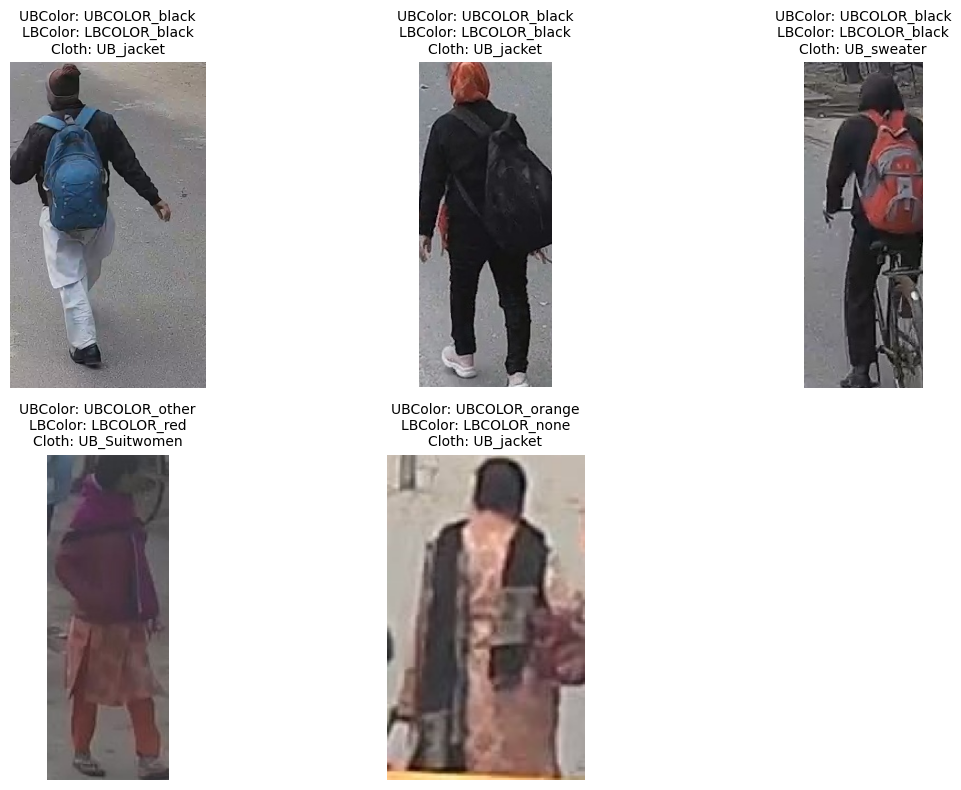

In [25]:
import random
import matplotlib.pyplot as plt

samples = df_pred.sample(5, random_state=42)
plt.figure(figsize=(12,8))

for i, row in enumerate(samples.itertuples(), 1):
    img = Image.open(f"/kaggle/input/scsdata/images_serialized/{row.image_id}.jpg")
    plt.subplot(2, 3, i)
    plt.imshow(img)
    plt.axis('off')
    title = (
        f"UBColor: {row.Upper_Body_Color_label}\n"
        f"LBColor: {row.Lower_Body_Color_label}\n"
        f"Cloth: {row.Upper_Body_Clothing_label}"
    )
    plt.title(title, fontsize=10)

plt.tight_layout()
plt.show()


# Vision Transformer(ViT)

In [17]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from torchvision.models import vit_b_16, ViT_B_16_Weights
from PIL import Image
from tqdm import tqdm

class VRLDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df        = df.reset_index(drop=True)
        self.img_dir   = img_dir
        self.transform = transform
        self.label_cols = [f"{cat.replace(' ','_')}_idx" for cat in category_mapping]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(f"{self.img_dir}/{row.image_id}.jpg").convert("RGB")
        if self.transform:
            img = self.transform(img)
        labels = torch.tensor([row[c] for c in self.label_cols], dtype=torch.long)
        return img, labels

normalize = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
train_tfm = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(), normalize,
])
val_tfm = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(), normalize,
])

img_folder = '/kaggle/input/vr-chal/VRLChallenge_2.O/images'
train_ds = VRLDataset(train_df, img_folder, transform=train_tfm)
val_ds   = VRLDataset(val_df,   img_folder, transform=val_tfm)
test_ds  = VRLDataset(test_df,  img_folder, transform=val_tfm)

y = train_df['Upper_Body_Clothing_idx'].values
inv_freq = 1.0 / torch.bincount(torch.tensor(y))
sample_weights = inv_freq[y]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(y), replacement=True)

train_loader = DataLoader(train_ds, batch_size=4, sampler=sampler, num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False,    num_workers=4)
test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=False,    num_workers=4)

vit_backbone = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
feat_dim     = vit_backbone.heads[-1].in_features
vit_backbone.heads = nn.Identity()

class MultiHeadModel(nn.Module):
    def __init__(self, backbone, mapping):
        super().__init__()
        self.backbone = backbone
        self.heads = nn.ModuleDict({
            cat.replace(' ','_'): nn.Linear(feat_dim, len(cols))
            for cat, cols in mapping.items()
        })

    def forward(self, x):
        feat = self.backbone(x)        # (B, feat_dim)
        return {name: head(feat) for name, head in self.heads.items()}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = MultiHeadModel(vit_backbone, category_mapping).to(device)

label_cols = [f"{cat.replace(' ','_')}_idx" for cat in category_mapping]
criterions = {
    lc: nn.CrossEntropyLoss(weight=class_weights[lc].to(device))
    for lc in label_cols
}
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)
scaler    = torch.cuda.amp.GradScaler()

num_epochs        = 25
patience          = 5
epochs_no_improve = 0
best_val_loss     = float('inf')
save_path         = 'best_model_vit.pth'

for epoch in range(1, num_epochs+1):
    model.train()
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch} [Train]"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(imgs)
            loss = sum(
                criterions[label_cols[i]](outputs[cat.replace(' ','_')], labels[:,i])
                for i, cat in enumerate(category_mapping)
            )
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    scheduler.step()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch} [Val]"):
            imgs, labels = imgs.to(device), labels.to(device)
            with torch.cuda.amp.autocast():
                outputs = model(imgs)
                val_loss += sum(
                    criterions[label_cols[i]](outputs[cat.replace(' ','_')], labels[:,i])
                    for i, cat in enumerate(category_mapping)
                ).item()

    avg_val = val_loss / len(val_loader)
    print(f"Epoch {epoch} | Val Loss: {avg_val:.4f}")

    if avg_val < best_val_loss:
        best_val_loss     = avg_val
        epochs_no_improve = 0
        torch.save(model.state_dict(), save_path)
        print("  ↳ New best model saved.")
    else:
        epochs_no_improve += 1
        print(f"  ↳ No improvement for {epochs_no_improve} epochs.")
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch}.")
            break



/tmp/ipykernel_35/3340796869.py:98: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = torch.cuda.amp.GradScaler()
Epoch 1 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]/tmp/ipykernel_35/3340796869.py:115: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1 [Val]:   0%|          | 0/27 [00:00<?, ?it/s]/tmp/ipykernel_35/3340796869.py:132: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1 [Val]: 100%|██████████| 27/27 [00:01<00:00, 18.26it/s]


Epoch 1 | Val Loss: 14.7929
  ↳ New best model saved.


Epoch 2 [Val]: 100%|██████████| 27/27 [00:01<00:00, 18.24it/s]


Epoch 2 | Val Loss: 11.9411
  ↳ New best model saved.


Epoch 3 [Val]: 100%|██████████| 27/27 [00:01<00:00, 18.34it/s]


Epoch 3 | Val Loss: 11.5371
  ↳ New best model saved.


Epoch 4 [Val]: 100%|██████████| 27/27 [00:01<00:00, 18.36it/s]


Epoch 4 | Val Loss: 11.6321
  ↳ No improvement for 1 epochs.


Epoch 5 [Val]: 100%|██████████| 27/27 [00:01<00:00, 18.27it/s]


Epoch 5 | Val Loss: 10.2334
  ↳ New best model saved.


Epoch 6 [Val]: 100%|██████████| 27/27 [00:01<00:00, 18.30it/s]


Epoch 6 | Val Loss: 10.4151
  ↳ No improvement for 1 epochs.


Epoch 7 [Val]: 100%|██████████| 27/27 [00:01<00:00, 18.27it/s]


Epoch 7 | Val Loss: 10.2666
  ↳ No improvement for 2 epochs.


Epoch 8 [Val]: 100%|██████████| 27/27 [00:01<00:00, 18.25it/s]


Epoch 8 | Val Loss: 10.4308
  ↳ No improvement for 3 epochs.


Epoch 9 [Val]: 100%|██████████| 27/27 [00:01<00:00, 17.92it/s]


Epoch 9 | Val Loss: 10.3615
  ↳ No improvement for 4 epochs.


Epoch 10 [Val]: 100%|██████████| 27/27 [00:01<00:00, 18.16it/s]

Epoch 10 | Val Loss: 10.3611
  ↳ No improvement for 5 epochs.
Early stopping at epoch 10.


In [18]:
model.load_state_dict(torch.load(save_path))
model.eval()

correct       = torch.zeros(len(label_cols), device=device)
exact_matches = 0
total         = 0

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Test"):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        bs = imgs.size(0)
        total += bs

        # per-head accuracy
        for i, cat in enumerate(category_mapping):
            head  = cat.replace(' ','_')
            preds = outputs[head].argmax(dim=1)
            correct[i] += (preds == labels[:,i]).sum().item()

        # exact-match
        stack = torch.stack([
            outputs[cat.replace(' ','_')].argmax(dim=1)
            for cat in category_mapping
        ], dim=1)
        exact_matches += stack.eq(labels).all(dim=1).sum().item()

print("\nTest Accuracies by Category:")
for i, cat in enumerate(category_mapping):
    print(f"  {cat:20s}: {correct[i]/total:.3f}")

num_heads = len(label_cols)
micro_acc = correct.sum().item() / (total * num_heads)
exact_acc = exact_matches / total
print(f"\nMicro-accuracy (all labels):               {micro_acc:.3f}")
print(f"Exact-match accuracy (all heads correct): {exact_acc:.3f}")


Test: 100%|██████████| 27/27 [00:01<00:00, 25.39it/s]


Test Accuracies by Category:
  Upper Body Color    : 0.632
  Lower Body Color    : 0.547
  Upper Body Clothing : 0.547
  Lower Body Clothing : 0.604
  Sleeves Length      : 0.736
  Carry               : 0.594
  Accessory           : 0.708
  Footwear            : 0.566
  Pose                : 0.925
  View                : 0.708

Micro-accuracy (all labels):               0.657
Exact-match accuracy (all heads correct): 0.028


# Swin Transformer

In [43]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from torchvision.models import swin_b, Swin_B_Weights
from PIL import Image
from tqdm import tqdm

class VRLDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df        = df.reset_index(drop=True)
        self.img_dir   = img_dir
        self.transform = transform
        self.label_cols = [f"{cat.replace(' ','_')}_idx" for cat in category_mapping]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(f"{self.img_dir}/{row.image_id}.jpg").convert("RGB")
        if self.transform:
            img = self.transform(img)
        labels = torch.tensor([row[c] for c in self.label_cols], dtype=torch.long)
        return img, labels

normalize = transforms.Normalize(mean=[0.485,0.456,0.406],
                                 std =[0.229,0.224,0.225])
train_tfm = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(), normalize,
])
val_tfm = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(), normalize,
])

img_folder   = '/kaggle/input/vr-chal/VRLChallenge_2.O/images'
train_ds     = VRLDataset(train_df, img_folder, transform=train_tfm)
val_ds       = VRLDataset(val_df,   img_folder, transform=val_tfm)
test_ds      = VRLDataset(test_df,  img_folder, transform=val_tfm)

y           = train_df['Upper_Body_Clothing_idx'].values
inv_freq    = 1.0 / torch.bincount(torch.tensor(y))
sample_wts  = inv_freq[y]
sampler     = WeightedRandomSampler(sample_wts, num_samples=len(y), replacement=True)

train_loader = DataLoader(train_ds, batch_size= 4, sampler=sampler, num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size= 4, shuffle=False,    num_workers=4)
test_loader  = DataLoader(test_ds,  batch_size= 4, shuffle=False,    num_workers=4)

swin_backbone = swin_b(weights=Swin_B_Weights.IMAGENET1K_V1)
feat_dim      = swin_backbone.head.in_features
swin_backbone.head = nn.Identity()

class MultiHeadModel(nn.Module):
    def __init__(self, backbone, mapping):
        super().__init__()
        self.backbone = backbone
        self.heads = nn.ModuleDict({
            cat.replace(' ', '_'): nn.Linear(feat_dim, len(cols))
            for cat, cols in mapping.items()
        })

    def forward(self, x):
        feat = self.backbone(x).view(x.size(0), -1)
        return {name: head(feat) for name, head in self.heads.items()}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = MultiHeadModel(swin_backbone, category_mapping).to(device)

label_cols = [f"{cat.replace(' ','_')}_idx" for cat in category_mapping]
criterions = {
    lc: nn.CrossEntropyLoss(weight=class_weights[lc].to(device))
    for lc in label_cols
}
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)
scaler    = torch.cuda.amp.GradScaler()

num_epochs        = 25
patience          = 5
epochs_no_improve = 0
best_val_loss     = float('inf')
save_path         = 'best_model_swin.pth'

for epoch in range(1, num_epochs+1):
    model.train()
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch} [Train]"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(imgs)
            loss = sum(
                criterions[label_cols[i]](
                    outputs[cat.replace(' ','_')], labels[:, i]
                )
                for i, cat in enumerate(category_mapping)
            )
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    scheduler.step()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch} [Val]"):
            imgs, labels = imgs.to(device), labels.to(device)
            with torch.cuda.amp.autocast():
                outputs = model(imgs)
                val_loss += sum(
                    criterions[label_cols[i]](
                        outputs[cat.replace(' ','_')], labels[:, i]
                    )
                    for i, cat in enumerate(category_mapping)
                ).item()

    avg_val = val_loss / len(val_loader)
    print(f"Epoch {epoch:02d} | Val Loss: {avg_val:.4f}")

    if avg_val < best_val_loss:
        best_val_loss     = avg_val
        epochs_no_improve = 0
        torch.save(model.state_dict(), save_path)
        print("  ↳ New best model saved.")
    else:
        epochs_no_improve += 1
        print(f"  ↳ No improvement for {epochs_no_improve} epochs.")
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch}.")
            break



/tmp/ipykernel_35/530077091.py:93: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = torch.cuda.amp.GradScaler()
Epoch 1 [Train]:   0%|          | 0/123 [00:00<?, ?it/s]/tmp/ipykernel_35/530077091.py:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1 [Val]:   0%|          | 0/27 [00:00<?, ?it/s]/tmp/ipykernel_35/530077091.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1 [Val]: 100%|██████████| 27/27 [00:01<00:00, 20.02it/s]


Epoch 01 | Val Loss: 13.8697
  ↳ New best model saved.


Epoch 2 [Val]: 100%|██████████| 27/27 [00:01<00:00, 20.10it/s]


Epoch 02 | Val Loss: 12.2824
  ↳ New best model saved.


Epoch 3 [Val]: 100%|██████████| 27/27 [00:01<00:00, 20.05it/s]


Epoch 03 | Val Loss: 12.3410
  ↳ No improvement for 1 epochs.


Epoch 4 [Val]: 100%|██████████| 27/27 [00:01<00:00, 19.54it/s]


Epoch 04 | Val Loss: 12.2639
  ↳ New best model saved.


Epoch 5 [Val]: 100%|██████████| 27/27 [00:01<00:00, 19.84it/s]


Epoch 05 | Val Loss: 11.9935
  ↳ New best model saved.


Epoch 6 [Val]: 100%|██████████| 27/27 [00:01<00:00, 19.98it/s]


Epoch 06 | Val Loss: 11.3940
  ↳ New best model saved.


Epoch 7 [Val]: 100%|██████████| 27/27 [00:01<00:00, 20.11it/s]


Epoch 07 | Val Loss: 12.0402
  ↳ No improvement for 1 epochs.


Epoch 8 [Val]: 100%|██████████| 27/27 [00:01<00:00, 19.48it/s]


Epoch 08 | Val Loss: 11.9422
  ↳ No improvement for 2 epochs.


Epoch 9 [Val]: 100%|██████████| 27/27 [00:01<00:00, 20.24it/s]


Epoch 09 | Val Loss: 11.6681
  ↳ No improvement for 3 epochs.


Epoch 10 [Val]: 100%|██████████| 27/27 [00:01<00:00, 19.71it/s]


Epoch 10 | Val Loss: 11.5683
  ↳ No improvement for 4 epochs.


Epoch 11 [Val]: 100%|██████████| 27/27 [00:01<00:00, 19.74it/s]

Epoch 11 | Val Loss: 11.9642
  ↳ No improvement for 5 epochs.
Early stopping at epoch 11.


In [44]:
model.load_state_dict(torch.load(save_path))
model.eval()

correct       = torch.zeros(len(label_cols), device=device)
exact_matches = 0
total         = 0

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Test"):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        bs = imgs.size(0)
        total += bs

        for i, cat in enumerate(category_mapping):
            head  = cat.replace(' ','_')
            preds = outputs[head].argmax(dim=1)
            correct[i] += (preds == labels[:, i]).sum().item()
            
        stack = torch.stack([
            outputs[cat.replace(' ','_')].argmax(dim=1)
            for cat in category_mapping
        ], dim=1)
        exact_matches += stack.eq(labels).all(dim=1).sum().item()

print("\nTest Accuracies by Category:")
for i, cat in enumerate(category_mapping):
    print(f"  {cat:20s}: {correct[i]/total:.3f}")

num_heads = len(label_cols)
micro_acc = correct.sum().item() / (total * num_heads)
exact_acc = exact_matches / total
print(f"\nMicro-accuracy (all labels):               {micro_acc:.3f}")
print(f"Exact-match accuracy (all heads correct): {exact_acc:.3f}")


Test: 100%|██████████| 27/27 [00:01<00:00, 18.79it/s]


Test Accuracies by Category:
  Upper Body Color    : 0.679
  Lower Body Color    : 0.538
  Upper Body Clothing : 0.453
  Lower Body Clothing : 0.717
  Sleeves Length      : 0.736
  Carry               : 0.689
  Accessory           : 0.840
  Footwear            : 0.594
  Pose                : 0.943
  View                : 0.736

Micro-accuracy (all labels):               0.692
Exact-match accuracy (all heads correct): 0.038
